In [22]:
include("src/StMrfTracking.jl")
import StMrfTracking

include("src/Tracking.jl")

import Tracking
T = Tracking;

include("src/GcWrappers.jl")
include("src/StMrf.jl")
import StMrf
SM = StMrf;

include("src/Labeler.jl")
import Labeler
L = Labeler;

B = StMrfTracking.ImgBlock;

In [18]:
using Cxx
using PyCall
using PyPlot
import Images

@pyimport imageio
@pyimport skimage.filters as filters
@pyimport skimage.morphology as morphology
disk = morphology.disk;

In [4]:
video_file = "/home/viktor/VirtualBox VMs/Shared/VehicleTracking/vehicle_videos/4K_p2.mp4"
# video_file = "/home/viktor/VirtualBox VMs/Shared/VehicleTracking/vehicle_videos/ch02_20180330092923.mp4"
# video_file = "/home/viktor/VirtualBox VMs/Shared/VehicleTracking/vehicle_videos/ch02_20180329160010.mp4"
out_video_file = join(splitdir(video_file), "/st_mrf_out/");

In [5]:
reader = imageio.get_reader(video_file);

In [6]:
reader[:get_length]()

522

In [24]:
frame_step = 2;

reader = imageio.get_reader(video_file);

frames = T.read_all_data(reader; frame_step=frame_step)

@time background = T.init_background(frames[1:min(300, size(frames, 1))]; max_iters=3);

 81.313551 seconds (510.57 k allocations: 29.693 GiB, 2.15% gc time)


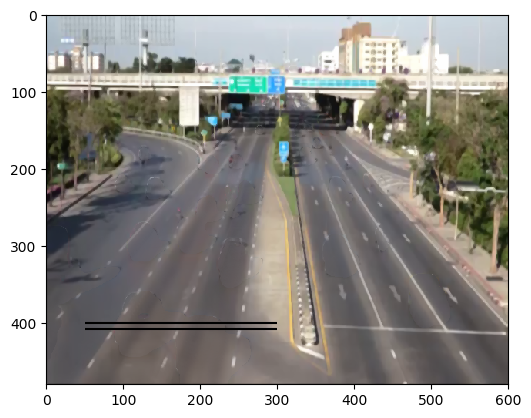

In [60]:
slit_x = 50;
slit_y = 400;
slit_width = 250;

block_width = 10;
block_height = 8;

imshow(background)
PyPlot.hlines(slit_y, xmin=slit_x, xmax=slit_x + slit_width)
PyPlot.hlines(slit_y + block_height, xmin=slit_x, xmax=slit_x + slit_width);

In [61]:
threshold = 0.05;

In [75]:
blocks = B.init_field(size(background)[1:2], (block_height, block_width))

slit_coords = [B.get_block_coords(slit_y, slit_x + i * block_width, block_height, block_width) for i in 1:floor(Int, slit_width / block_width)]
slit_line = [blocks[c...] for c in slit_coords];

new_object_id = 1;

In [65]:
writer = imageio.get_writer(out_video_file, fps=reader[:get_meta_data]()["fps"] / frame_step);

# for f_id in 1:size(frames, 1)
for f_id in 1:5
    if f_id >= size(frames, 1)
        break
    end
    
    if f_id % 100 == 0
        println("Frame $f_id")
    end
    
    global frame = frames[f_id];
    global prev_pixel_map = B.blocks_to_object_map(blocks);
    SM.update_slit_objects!(blocks, slit_coords, frame, background, new_object_id; threshold=threshold);
    
    global old_frame = frame;
    frame = frames[f_id + 1];

    obj_ids_map = map(b -> b.object_id, blocks);

    global object_ids = sort(unique(obj_ids_map));
    object_ids = object_ids[object_ids .> 0]
    group_coords = [collect(zip(findn(obj_ids_map .== id)...)) for id in object_ids]
    global motion_vecs = [SM.find_motion_vector(blocks, frame, old_frame, gc) for gc in group_coords]
    
    labels = zeros(Int, size(blocks))
    if size(motion_vecs, 1) != 0
        motion_vecs_rounded = [SM.round_motion_vector(mv, block_width, block_height) for mv in motion_vecs]
        global new_map = SM.update_object_ids(blocks, obj_ids_map, motion_vecs_rounded, group_coords, frame, background; 
                                       threshold=threshold);
#         new_map[map(x -> x.end_y, blocks) .< slit_y] = Set();
        new_map[map(x -> x.end_y, blocks) .> slit_y + block_height] = Set();

        labels = L.label_map_gco(blocks, new_map, motion_vecs, prev_pixel_map, frame, old_frame);
        labels = Images.label_components(labels, trues(3, 3))
    end

    
    new_object_id = maximum(labels) + 1
    B.set_block_ids!(blocks, labels)
    
    f_id += 1
    
    obj_map = B.blocks_to_object_map(blocks)
    out_frame = T.plot_frame_to_array(frame, slit_x, slit_y, slit_width, block_height; object_map=obj_map, plot_boxes=true)
    writer[:append_data](out_frame)
end

writer[:close]()
# T.plot_frame(frame, slit_x, slit_y, slit_width, block_height; object_map=SM.blocks_to_object_map(blocks), plot_boxes=true);

/home/viktor/local/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/viktor/local/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/viktor/local/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
[swscaler @ 0x176f1e0] Warning: data is not aligned! This can lead to a spee

TODO:
1. Write viedos
2. Shadow suppression
3. Reverse MRF

## Shadow suppression

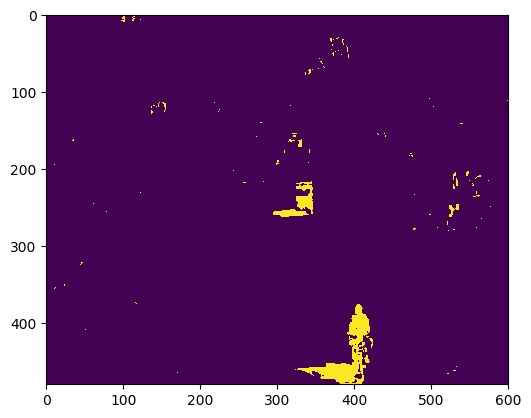

In [67]:
foreground = T.subtract_background(frame, background);
imshow(foreground);

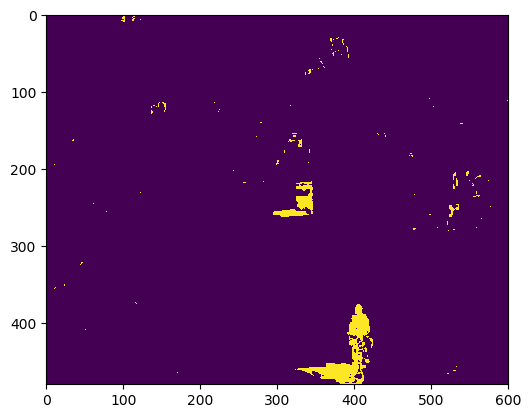

PyObject <matplotlib.image.AxesImage object at 0x7fab730df9e8>

In [68]:
imshow(foreground .& .!T.shadow_mask(frame, background))

In [1111]:
include("src/Tracking.jl")

import Tracking
T = Tracking;

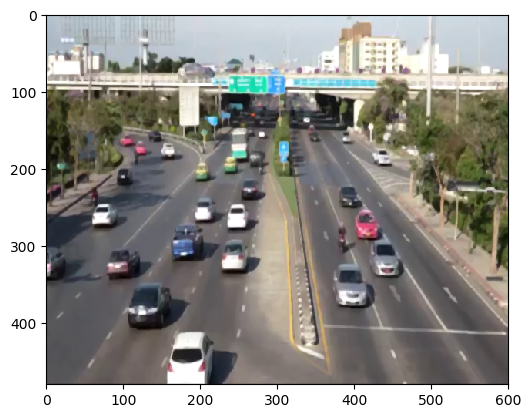

PyObject <matplotlib.image.AxesImage object at 0x7fc161dfffd0>

In [1363]:
imshow(frame)

## MRF debug

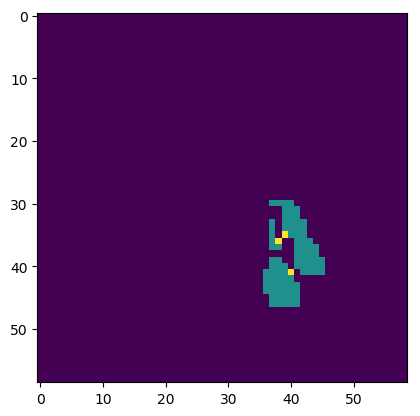

In [935]:
# imshow(prev_pixel_map);
imshow(map(length, new_map));

$U_N(N_{y_k})$: Pott's J = -$\alpha$;  
$M_{xy_k}$: number of overlapping pixel labels  
$D_{xy_k}$: image difference between a block in the previous frame and displaced block in the current frame;  

In [765]:
include("src/GcWrappers.jl")
import GcWrappers
GW = GcWrappers;

In [774]:
include("src/Labeler.jl")
import Labeler
L = Labeler;

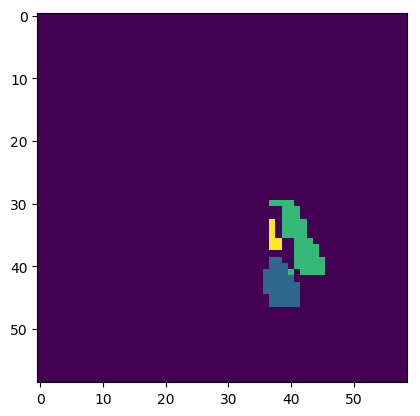

PyObject <matplotlib.image.AxesImage object at 0x7fc17ab70048>

In [936]:
imshow(L.label_map_gco(blocks, new_map, motion_vecs, prev_pixel_map, frame, old_frame))

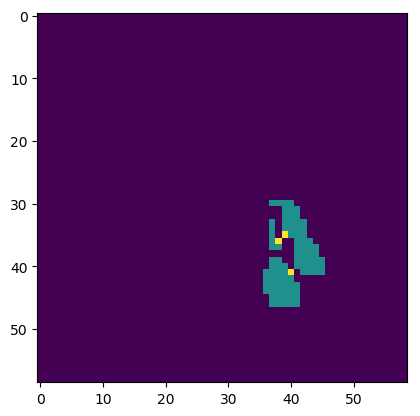

In [937]:
imshow(map(length, new_map));

In [938]:
tested_coords = collect(zip(findn(map(length, new_map) .> 1)...))

3-element Array{Tuple{Int64,Int64},1}:
 (37, 39)
 (36, 40)
 (42, 41)

In [940]:
new_map[tested_coords[3]...]

Set([2, 1])

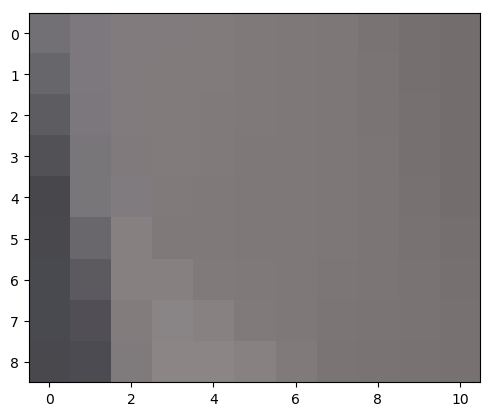

PyObject <matplotlib.image.AxesImage object at 0x7fc17ac24b70>

In [963]:
imshow(frame[block.coords()..., :])

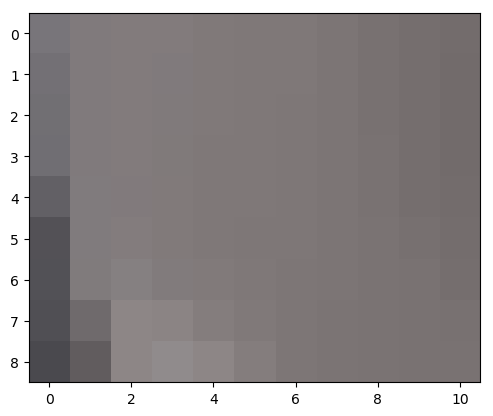

PyObject <matplotlib.image.AxesImage object at 0x7fc176211d30>

In [962]:
imshow(old_frame[block.coords(-1 .* motion_vecs[1])..., :])

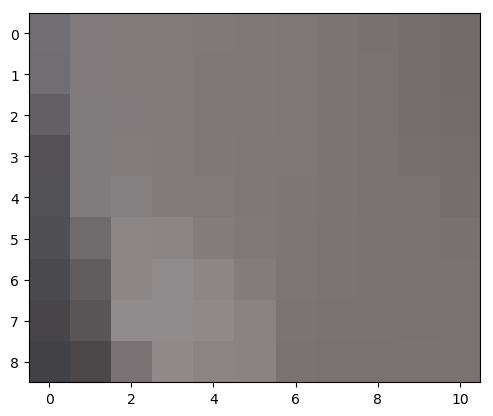

PyObject <matplotlib.image.AxesImage object at 0x7fc17aca82e8>

In [964]:
imshow(old_frame[block.coords(-1 .* motion_vecs[2])..., :])

In [960]:
obj_id = 2
block = blocks[tested_coords[3]...]

println([1 - cor(frame[block.coords()..., :][:], old_frame[block.coords(-1 .* motion_vecs[id])..., :][:]) for id in 1:2])
println([mean(abs.(frame[block.coords()..., :] .- old_frame[block.coords(-1 .* motion_vecs[id])..., :])) for id in 1:2])

println([mean(prev_pixel_map[block.coords(-1 .* motion_vecs[id])...] .!= id) for id in 1:2])

[0.134681, 0.0399572]
[0.0146168, 0.0116063]
[0.909091, 1.0]


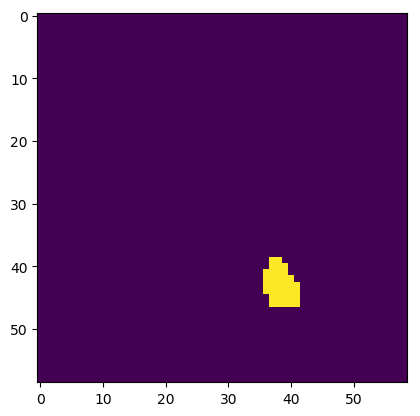

PyObject <matplotlib.image.AxesImage object at 0x7fc17a93db38>

In [959]:
# imshow(prev_pixel_map .== 1)
imshow(labels .== 1)

In [948]:
tested_ids = [GW.id_by_coords(c..., size(blocks, 1), zero_based=false) for c in tested_coords];
println(tested_ids)

[2279, 2337, 2402]


In [951]:
include("src/Labeler.jl")
import Labeler
L = Labeler;

group_coords2 = [collect(zip(findn(map(v -> lab in v, new_map))...)) for lab in object_ids];
L.unary_penalties(blocks, object_ids, motion_vecs, group_coords2, prev_pixel_map, frame, old_frame)[tested_ids,1:3]

3×3 Array{Int64,2}:
 -1000000  -1190      -225
 -1000000   -213     -1034
    -1044  -1040  -1000000

In [952]:
include("src/Labeler.jl")
import Labeler
L = Labeler;

group_coords2 = [collect(zip(findn(map(v -> lab in v, new_map))...)) for lab in object_ids];
L.unary_penalties(blocks, object_ids, motion_vecs, group_coords2, prev_pixel_map, frame, old_frame)[tested_ids,1:3]

3×3 Array{Int64,2}:
 -1000000  -1190      -225
 -1000000   -213     -1034
    -1044  -1040  -1000000